In [30]:
ls

Bc_epitopes_HLA_overlap-05-06-20.txt  Window_21mer-05-06-20.txt
Select vaccine peptides.ipynb         Window_21mer-05-07-20.csv
Window_15mer-05-06-20.txt             Window_27mer-05-06-20.txt
Window_15mer-05-07-20.csv             Window_27mer-05-07-20.csv


In [31]:
df_21mer = pd.read_csv("Window_21mer-05-07-20.csv")


In [32]:
df_27mer = pd.read_csv("Window_27mer-05-07-20.csv")


In [33]:
df_15mer = pd.read_csv("Window_15mer-05-07-20.csv")


In [34]:
bad_dipeptides_unc = {
   "DG", 
   "DS", 
   "DN", 
   "DD", 
   "NN", 
   "ND", 
   "NG", 
   "NS",
}

bad_dipeptides_jpt = {"NP"}

In [35]:
hydropathy_dict = {
    "A": 1.8,
    "C": 2.5,
    "D": -3.5,
    "E": -3.5,
    "F": 2.8,
    "G": -0.4,
    "H": -3.2,
    "I": 4.5,
    "K": -3.9,
    "L": 3.8,
    "M": 1.9,
    "N": -3.5,
    "P": -1.6,
    "Q": -3.5,
    "R": -4.5,
    "S": -0.8,
    "T": -0.7,
    "V": 4.2,
    "W": -0.9,
    "Y": -1.3
}

In [48]:

def gravy_score(amino_acids):
    """
    Mean amino acid hydropathy averaged across residues of a peptide
    or protein sequence.
    """
    total = 0 
    for aa in amino_acids:
        total += hydropathy_dict[aa]
    return total / len(amino_acids)


In [49]:

def max_kmer_gravy_score(amino_acids, k):
    """
    Returns max GRAVY score of any kmer in the amino acid sequence,
    used to determine if there are any extremely hydrophobic regions within a
    longer amino acid sequence.
    """
    return max(
        gravy_score(amino_acids[i:i + k])
        for i in range(len(amino_acids) - k + 1))


In [59]:
def max_short_subsequence_gravy_score(amino_acids):
    gravy_scores = [
        max_kmer_gravy_score(amino_acids, k)
        for k in [5, 6, 7, 8]
    ]
    return max(gravy_scores)


In [60]:


def difficult_c_terminal(amino_acids):
    return amino_acids[-1] in {"P", "C", "H"}

def difficult_n_terminal(amino_acids):
    """
    Is the N-terminus one of {Gln, Glu, Cys}?
    ---
    Priority I: avoid N-terminal Gln, Glu, Cys
    Priority II: Asparagine at the N-terminus of a peptide is also hard
    to synthesize, though not as bad as {Gln, Glu, Cys}
    """
    return amino_acids[0] in {"Q", "E", "C", "N"}


def cysteine_count(amino_acids):
    """
    How many cysteines are in the amino acid sequence?
    Problem with cysteine residues: They can form disulfide bonds across
    distant parts of the peptide
    """
    return amino_acids.count("C")

def num_difficult_dipeptides(amino_acids):
    total = 0
    for dipeptide in bad_dipeptides_unc.union(bad_dipeptides_jpt):
        total += amino_acids.count(dipeptide)
    return total

In [74]:
def annotate(df):
    df = df.copy()
    df["num_difficult_dipeptides"] = df.Sequence.map(num_difficult_dipeptides)
    df["num_cysteines"] = df.Sequence.map(cysteine_count)
    df["difficult_c_terminal"] = df.Sequence.map(difficult_c_terminal)
    df["difficult_n_terminal"] = df.Sequence.map(difficult_n_terminal)
    df["max_kmer_gravy"] = df.Sequence.map(max_short_subsequence_gravy_score)
    df["extreme_local_hydrophobicity"] = df.max_kmer_gravy > 2.5
    df["difficult_local_hydrophobicity"] = df.max_kmer_gravy > 1.5
    df["too_many_cysteines"] = df.num_cysteines > 1
    df["manufacturability_difficulty_score"] = (
        df.difficult_n_terminal.astype(float) +
        2.0 * df.num_difficult_dipeptides.astype(float) + 
        2.0 * df.difficult_c_terminal.astype(float) + 
        (df.max_kmer_gravy - 1.5).clip(lower=0) + 
        5.0 * (df.max_kmer_gravy - 2.5).clip(lower=0) + 
        (df.num_cysteines == 1) + 
        (10.0 * (df.num_cysteines - 1)).clip(lower=0) 
    )
    return df

df_27mer_annot = annotate(df_27mer);
df_27mer_annot.to_csv("vaccine-peptides-27mer-annotated-05-07-20.csv", index=False)
df_21mer_annot = annotate(df_21mer);
df_21mer_annot.to_csv("vaccine-peptides-21mer-annotated-05-07-20.csv", index=False)
df_15mer_annot = annotate(df_15mer)
df_15mer_annot.to_csv("vaccine-peptides-15mer-annotated-05-07-20.csv", index=False)




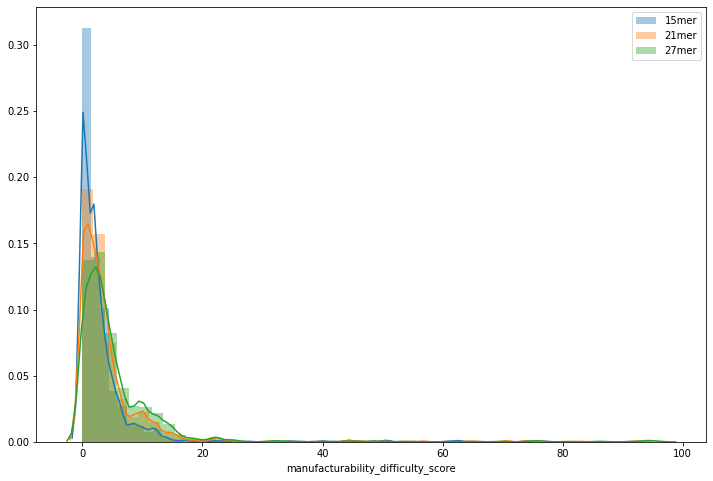

In [76]:
import seaborn 
import matplotlib 
from matplotlib import pyplot
fig = pyplot.figure(figsize=(12,8))
seaborn.distplot(df_15mer_annot.manufacturability_difficulty_score)
seaborn.distplot(df_21mer_annot.manufacturability_difficulty_score)
seaborn.distplot(df_27mer_annot.manufacturability_difficulty_score)
pyplot.legend(["15mer", "21mer", "27mer"])